In [2]:
import pandas as pd
from pathlib import Path
import pgeon.policy_graph as PG
from example.environment import SelfDrivingEnvironment
from nuscenes import NuScenes
import numpy as np
from matplotlib.patches import Rectangle

from nuscenes.map_expansion.map_api import NuScenesMap, NuScenesMapExplorer
from nuscenes.map_expansion import arcline_path_utils
import math
from typing import Tuple

from example.dataset.utils import create_rotated_rectangle
import matplotlib.pyplot as plt

In [3]:
#path where you stored the copy of the nuScenes dataset.
DATAROOT = Path('/home/saramontese/Desktop/MasterThesis/example/dataset/data/sets/nuscenes')

#MINI
nuscenes = NuScenes('v1.0-mini', dataroot=DATAROOT)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.488 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [4]:

dtype_dict = {
    'modality': 'category',  # for limited set of modalities, 'category' is efficient
    'scene_token': 'str',  
    'timestamp': 'str',  # To enable datetime operations
    'rotation': 'object',  # Quaternion (lists)
    'x': 'float64',
    'y': 'float64',
    'z': 'float64',
    'yaw': 'float64',  
    'velocity': 'float64',
    'acceleration': 'float64',
    'heading_change_rate': 'float64',
    'delta_local_x': 'float64',
    'delta_local_y': 'float64'}
df = pd.read_csv(DATAROOT / 'train_v1.0-mini_lidar_0.csv', dtype=dtype_dict, parse_dates=['timestamp'])
#df['detect_CAM_FRONT'] = df['detect_CAM_FRONT'].apply(lambda x: ast.literal_eval(x))
#df['detect_CAM_BACK'] = df['detect_CAM_BACK'].apply(lambda x: ast.literal_eval(x))
city ='singapore-hollandvillage' # 'boston-seaport' #'boston-seaport'#'singapore-onenorth' boston-seaport'#
df = df[df['location'] == city]
df.head()

,scene_token,steering_angle,location,modality,timestamp,rotation,x,y,z,yaw,velocity,acceleration,yaw_rate,delta_local_x,delta_local_y
202,d25718445d89453381c659b9c8734939,3.029892,singapore-hollandvillage,lidar,2018-11-21 11:39:27.947576,"[0.7117791302605412, -0.0043778325291723525, -...",608.858751,2011.052220,0.0,-1.557497,6.234642,NaN,0.474277,0.000000,0.000000
203,d25718445d89453381c659b9c8734939,2.940880,singapore-hollandvillage,lidar,2018-11-21 11:39:28.447460,"[0.789863481958287, 0.0016552328580890516, -0....",609.227471,2007.957511,0.0,-1.320414,6.234642,NaN,0.474277,-0.327533,3.099340
204,d25718445d89453381c659b9c8734939,2.279400,singapore-hollandvillage,lidar,2018-11-21 11:39:28.948430,"[0.8528977604944997, 0.0005375172497731908, 0....",610.384463,2004.811594,0.0,-1.098554,6.690875,0.910698,0.442861,-0.341437,3.334492
205,d25718445d89453381c659b9c8734939,1.872738,singapore-hollandvillage,lidar,2018-11-21 11:39:29.448339,"[0.8965811993783813, 0.0016462198909647716, 0....",612.235641,2001.769059,0.0,-0.917523,7.124184,0.866776,0.362127,-0.264566,3.551603
206,d25718445d89453381c659b9c8734939,0.731293,singapore-hollandvillage,lidar,2018-11-21 11:39:29.949334,"[0.9223652655739288, -0.0036955010565602737, 0...",614.784636,1998.776777,0.0,-0.793150,7.845971,1.440708,0.248252,-0.205478,3.925418


In [5]:
env = SelfDrivingEnvironment(city)
nusc_map = NuScenesMap(dataroot='example/dataset/data/sets/nuscenes', map_name = city)


Render

/home/saramontese/.local/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/saramontese/.local/lib/python3.8/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


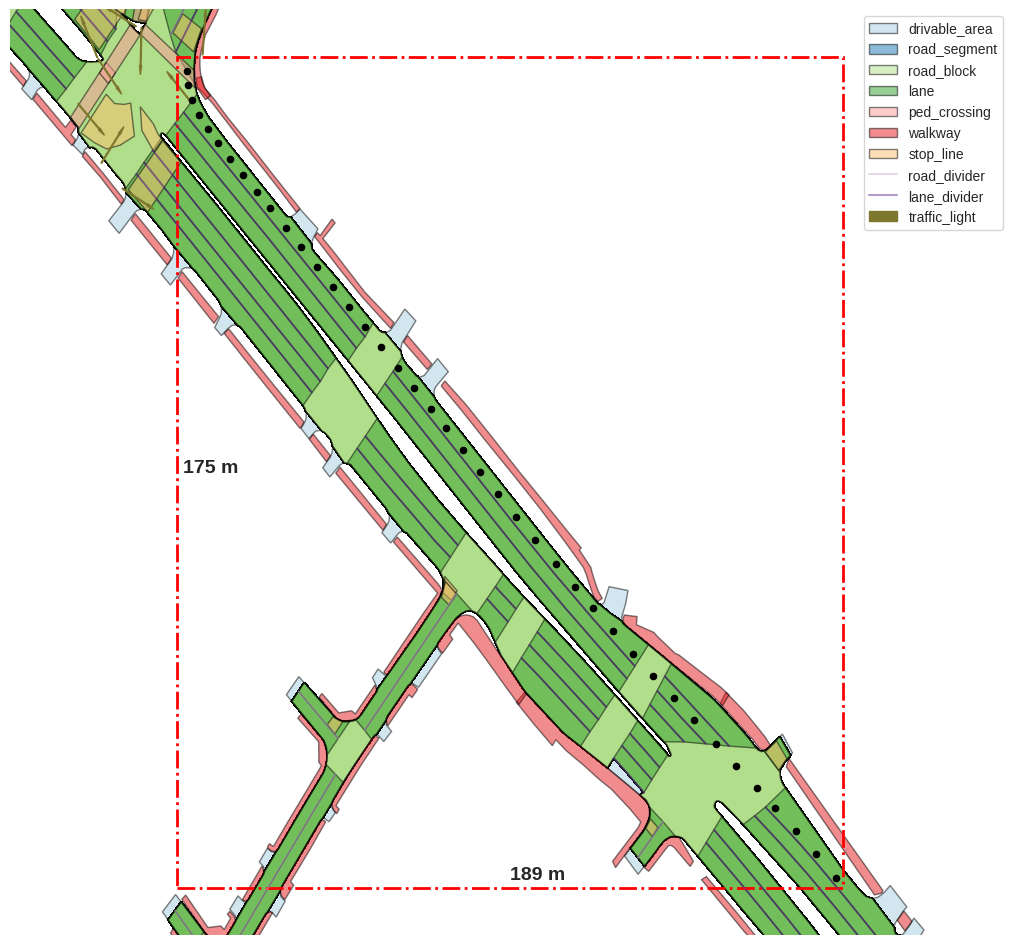

In [7]:
scene_test = df['scene_token'].unique()[0] #'295c6c85275e4376bc8446b4a76504cd'#
example_scene_df = df[df['scene_token']==scene_test]
ego_poses = nusc_map.render_egoposes_on_fancy_map(nuscenes, scene_tokens=[scene_test], verbose=False)


In [8]:
nuscenes.render_scene(scene_test)

Test progress discretization

In [8]:
for scene in df['scene_token'].unique():#['295c6c85275e4376bc8446b4a76504cd']:#
    example_scene_df = df[df['scene_token']==scene]
    print(f'SCENE {scene}')
    for i in range(example_scene_df.shape[0]):
        
        x,y,yaw = example_scene_df.iloc[i][['x','y', 'yaw']].tolist()
        
        lane_predicates = env.get_lane_info(x,y, yaw, eps=0.3, agent_size=(2,4))
        print(lane_predicates)
        if False:########
            #PLOT
            ########
            
            #render agent as a renctangle and show its heading direction compare to the direction of the lane
            #for each sample in the scene.
            road_segment_token = nusc_map.record_on_point(x,y, 'road_segment')
            current_lane = nusc_map.record_on_point(x,y, 'lane')

            if road_segment_token and nusc_map.get('road_segment', road_segment_token)['is_intersection'] and not current_lane:
                closest_lane = nusc_map.get_closest_lane(x, y, radius=2)
                lane_path = nusc_map.get_arcline_path(closest_lane)
                closest_pose_idx_to_lane, lane_record, _ = SelfDrivingEnvironment.project_pose_to_lane((x, y, yaw), lane_path)
                if closest_pose_idx_to_lane == len(lane_record) - 1:
                    tangent_vector = lane_record[closest_pose_idx_to_lane] - lane_record[closest_pose_idx_to_lane - 1]
                else:
                    tangent_vector = lane_record[closest_pose_idx_to_lane + 1] - lane_record[closest_pose_idx_to_lane]

            else:

                lane = nusc_map.get_arcline_path(current_lane)
                closest_pose_idx_to_lane, lane_record, distance_along_lane = SelfDrivingEnvironment.project_pose_to_lane((x, y, yaw), lane)
                if closest_pose_idx_to_lane == len(lane_record) - 1:
                        tangent_vector = lane_record[closest_pose_idx_to_lane] - lane_record[closest_pose_idx_to_lane - 1]
                else:
                    tangent_vector = lane_record[closest_pose_idx_to_lane + 1] - lane_record[closest_pose_idx_to_lane]

    
              
            patch_size = 20
            patch_box = [x,y, patch_size, patch_size]
            patch = NuScenesMapExplorer.get_patch_coord(patch_box)
            minx, miny, maxx, maxy = patch.bounds

            fig, ax = nusc_map.render_map_patch( [minx, miny, maxx, maxy], ['road_divider', 'lane_divider'], figsize=(5, 5))
            
            #ax.add_patch(Rectangle((x, y), agent_size[0], agent_size[1], yaw))
            ax.scatter(x,y)
            heading_vector = np.array([np.cos(yaw), np.sin(yaw)])

            yaw =  math.degrees(-(math.pi / 2) + yaw)
            rotated_rectangle = create_rotated_rectangle((x,y), yaw, (2,4))
            ax.quiver(x, y, heading_vector[0], heading_vector[1], color='b', scale=10, label='Ego Direction')
            ax.quiver(x,y, tangent_vector[0], tangent_vector[1],  color='r', scale=10, label='Lane Direction')
            x,y = rotated_rectangle.exterior.xy
            ax.plot(x,y)
            ax.set_title(lane_predicates)
            
    print('-------------------------')

SCENE 2fc3753772e241f2ab2cd16a784cc680
(<BlockProgress.END: 3>, <LanePosition.RIGHT: 3>)
(<BlockProgress.END: 3>, <LanePosition.RIGHT: 3>)
(<BlockProgress.END: 3>, <LanePosition.RIGHT: 3>)
(<BlockProgress.END: 3>, <LanePosition.RIGHT: 3>)
(<BlockProgress.END: 3>, <LanePosition.RIGHT: 3>)
(<BlockProgress.END: 3>, <LanePosition.RIGHT: 3>)
(<BlockProgress.INTERSECTION: 4>, <LanePosition.RIGHT: 3>)
(<BlockProgress.INTERSECTION: 4>, <LanePosition.RIGHT: 3>)
(<BlockProgress.INTERSECTION: 4>, <LanePosition.RIGHT: 3>)
(<BlockProgress.INTERSECTION: 4>, <LanePosition.RIGHT: 3>)
(<BlockProgress.INTERSECTION: 4>, <LanePosition.RIGHT: 3>)
(<BlockProgress.INTERSECTION: 4>, <LanePosition.RIGHT: 3>)
(<BlockProgress.INTERSECTION: 4>, <LanePosition.NONE: 4>)
(<BlockProgress.INTERSECTION: 4>, <LanePosition.RIGHT: 3>)
(<BlockProgress.INTERSECTION: 4>, <LanePosition.RIGHT: 3>)
(<BlockProgress.INTERSECTION: 4>, <LanePosition.RIGHT: 3>)
(<BlockProgress.INTERSECTION: 4>, <LanePosition.RIGHT: 3>)
(<BlockProgre

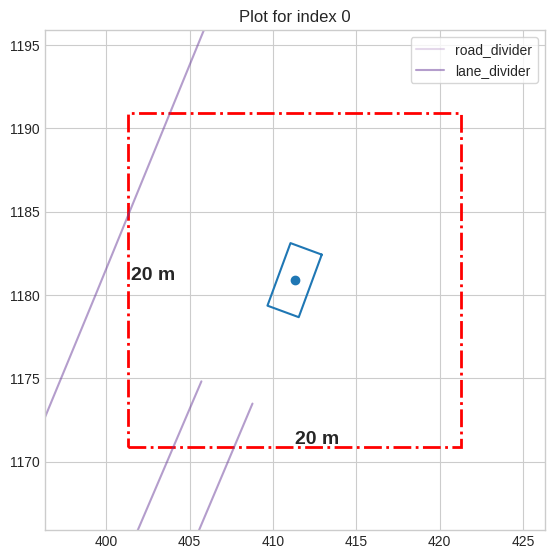

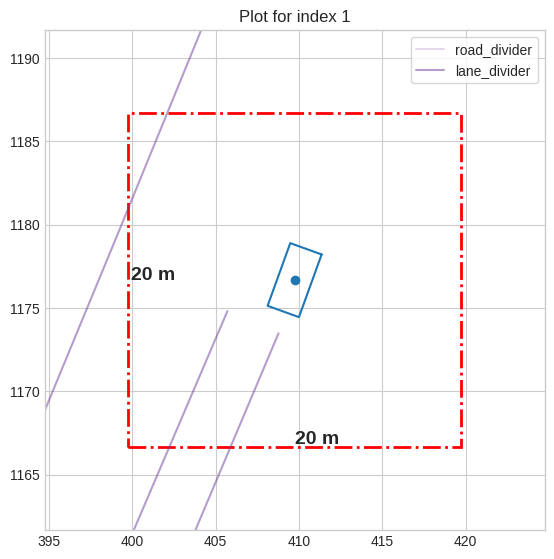

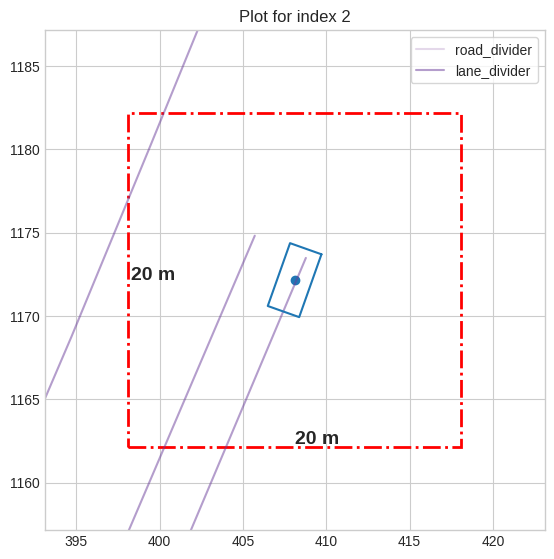

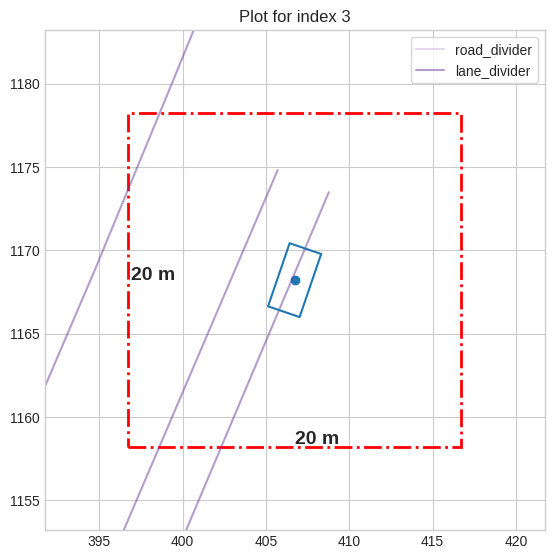

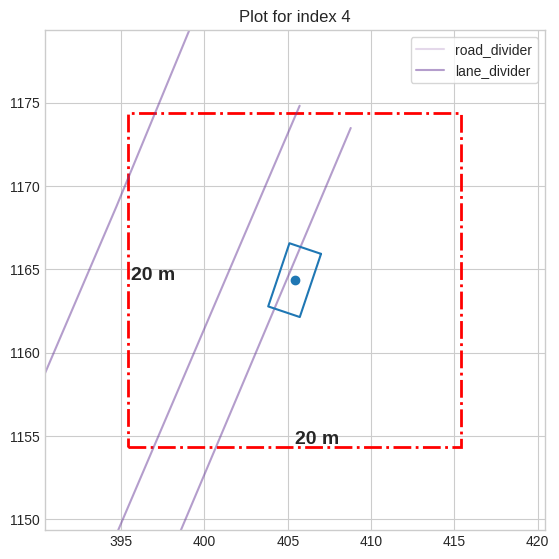

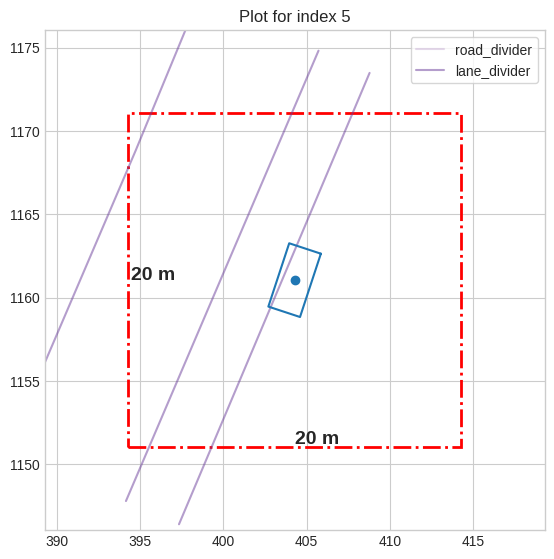

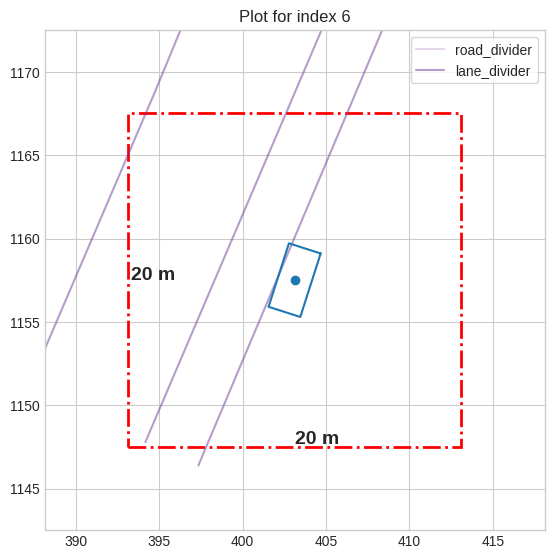

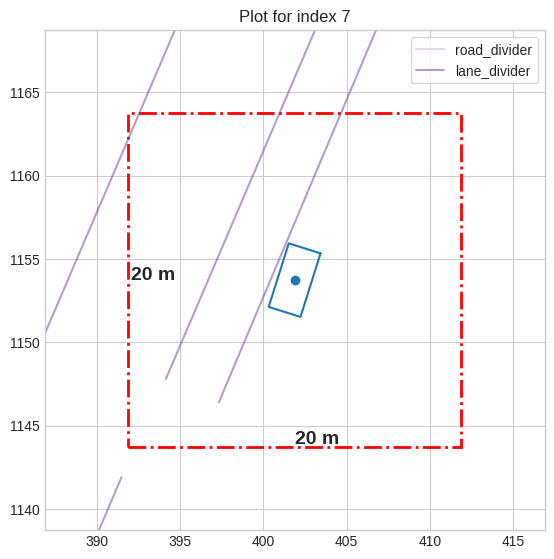

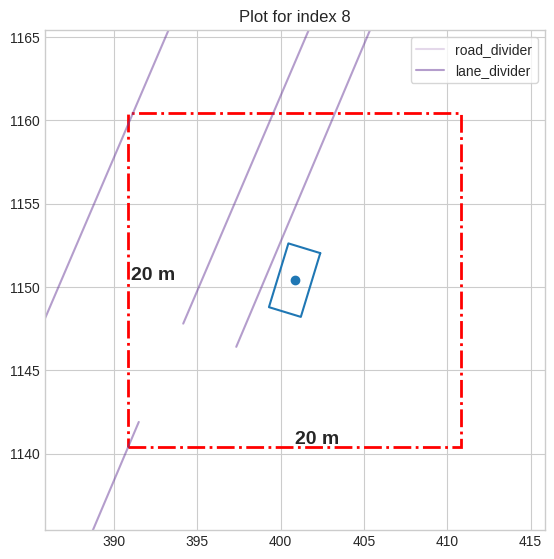

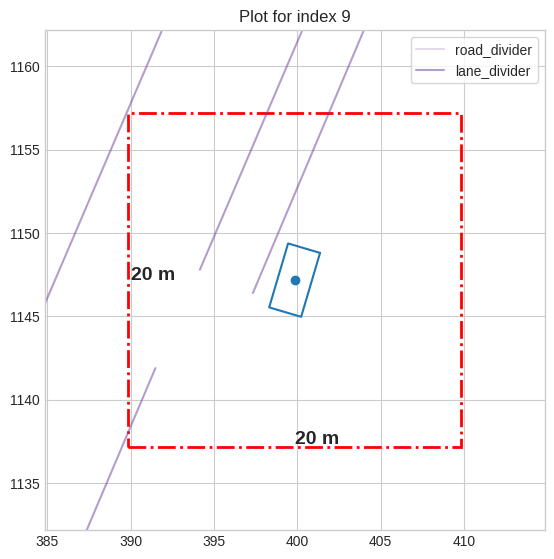

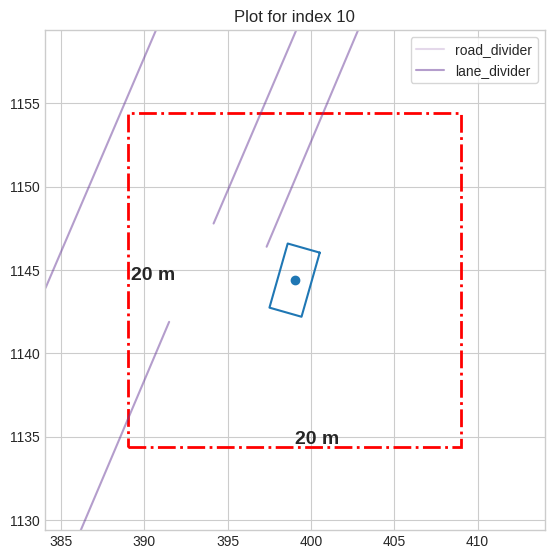

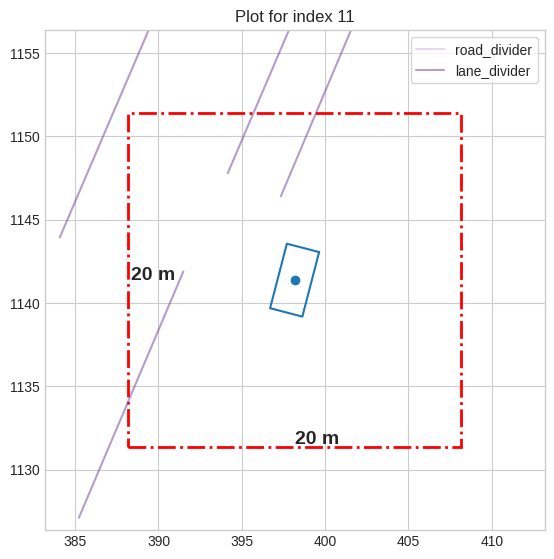

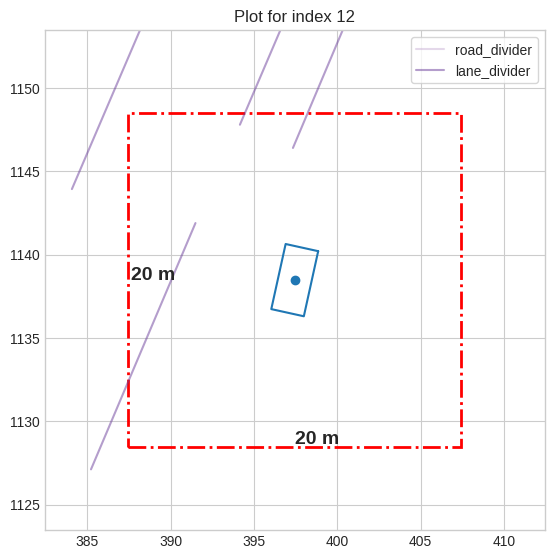

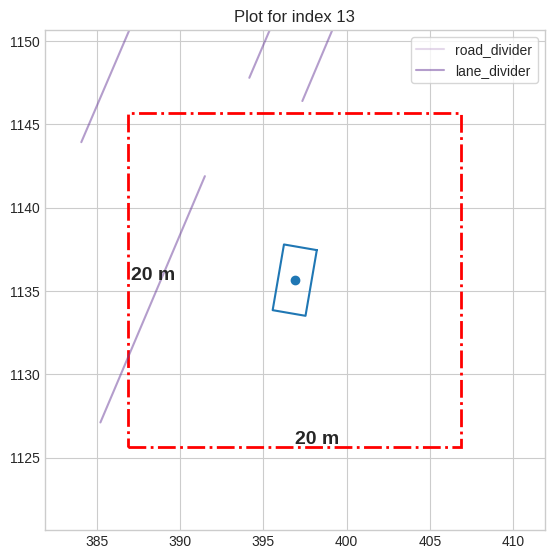

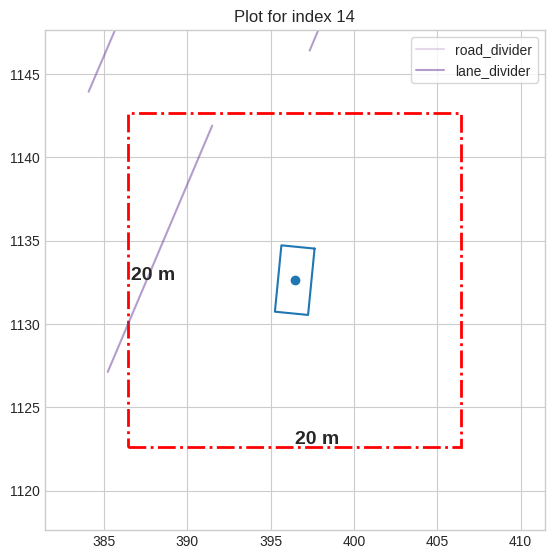

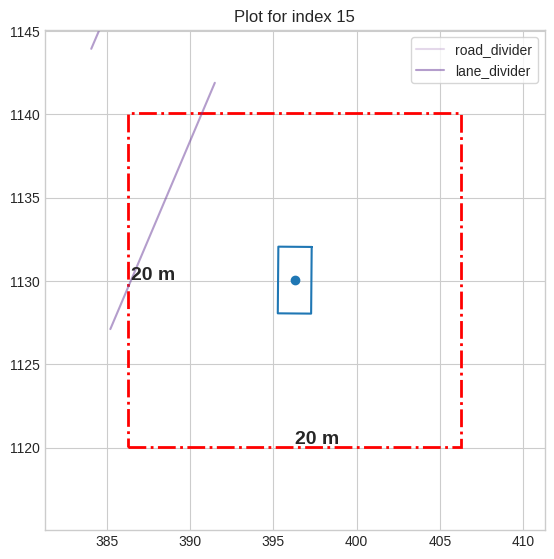

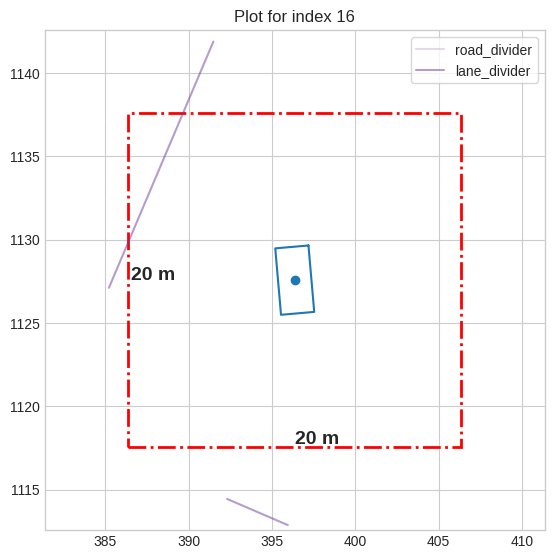

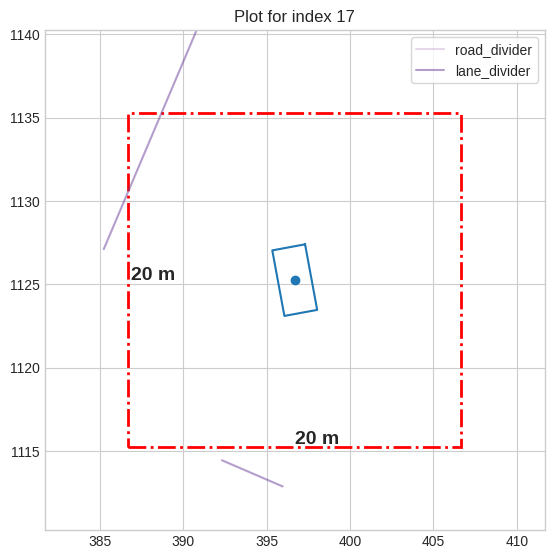

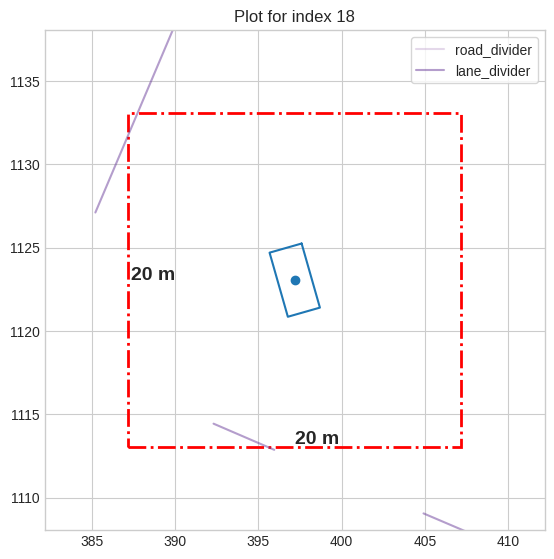

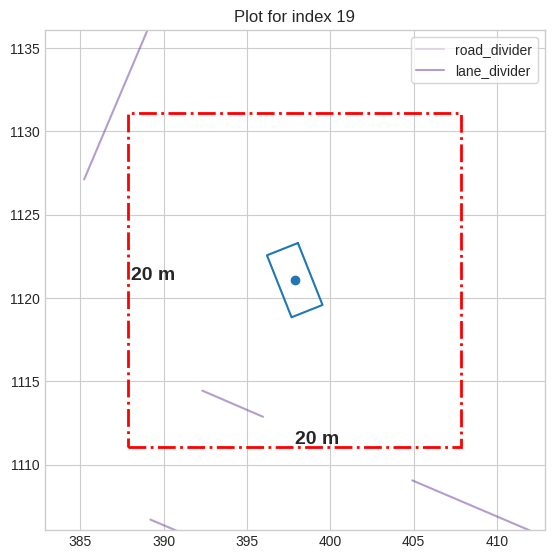

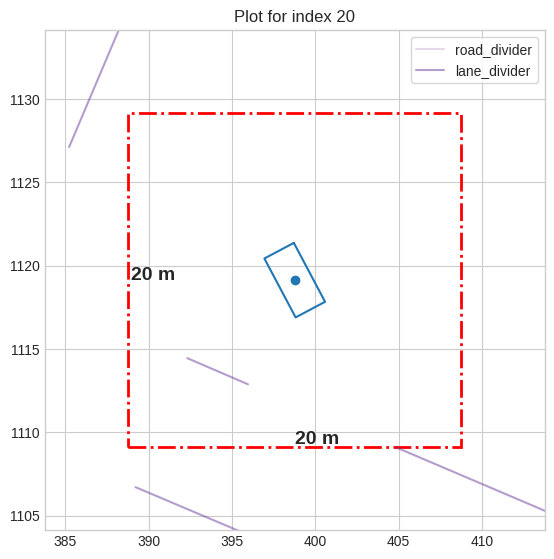

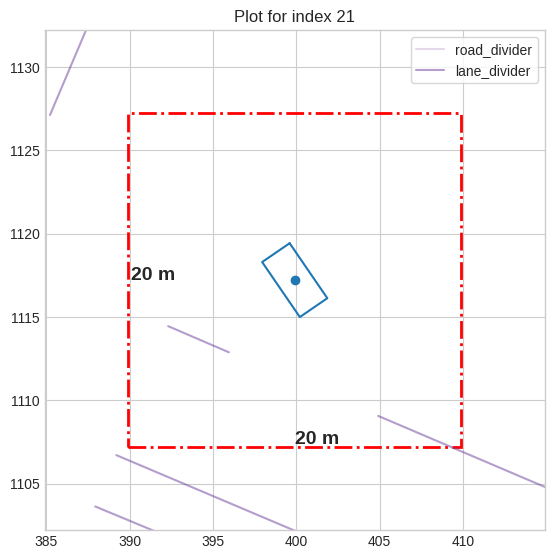

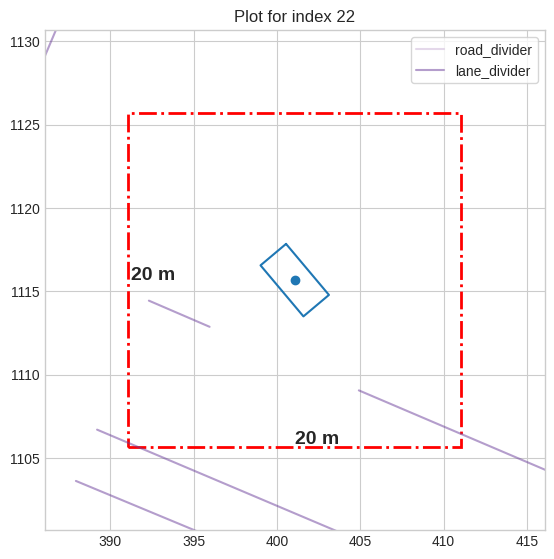

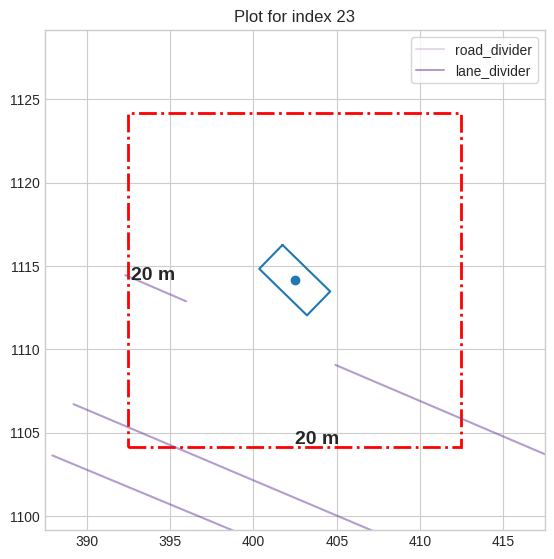

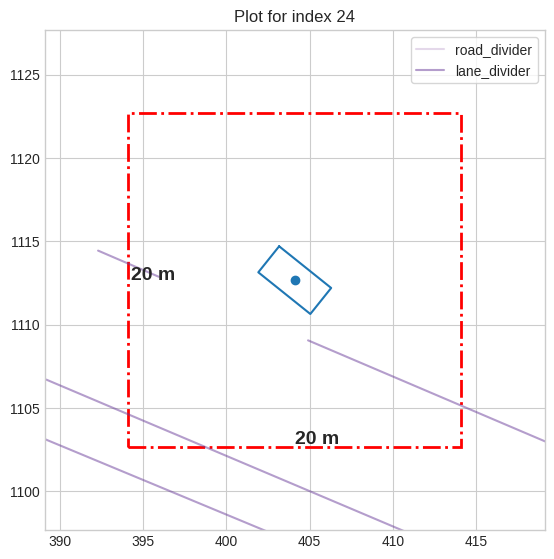

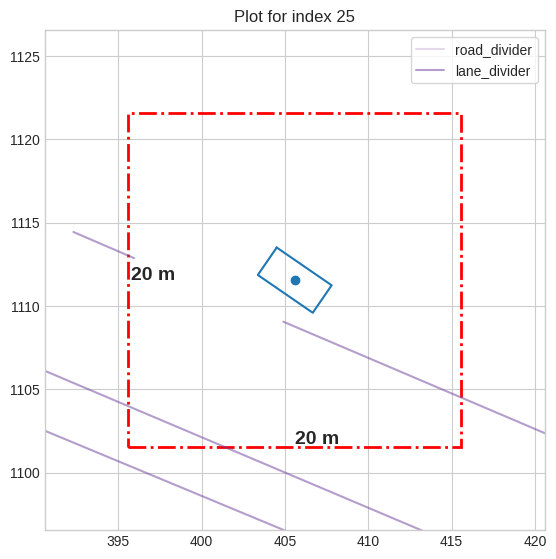

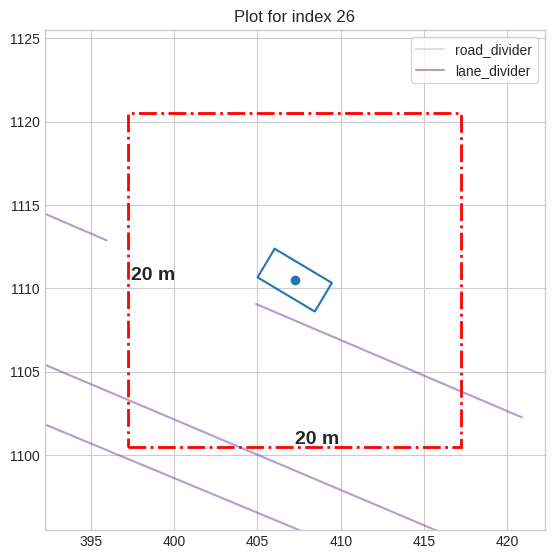

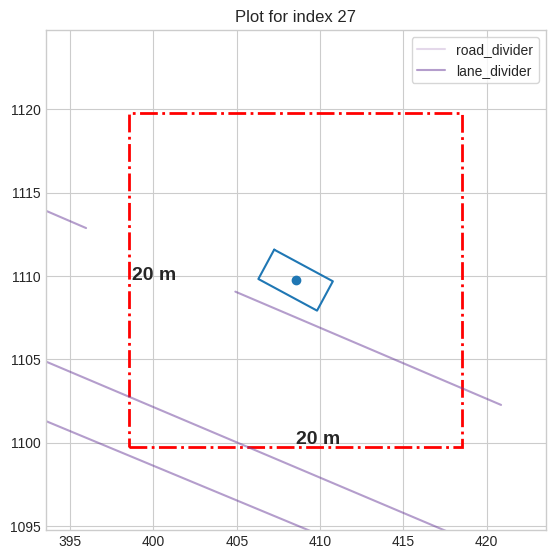

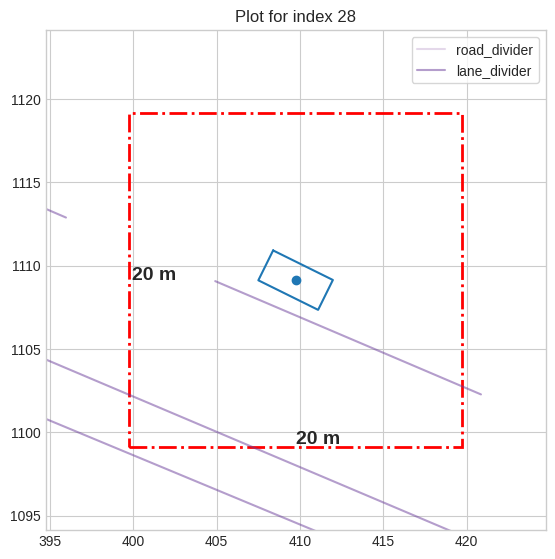

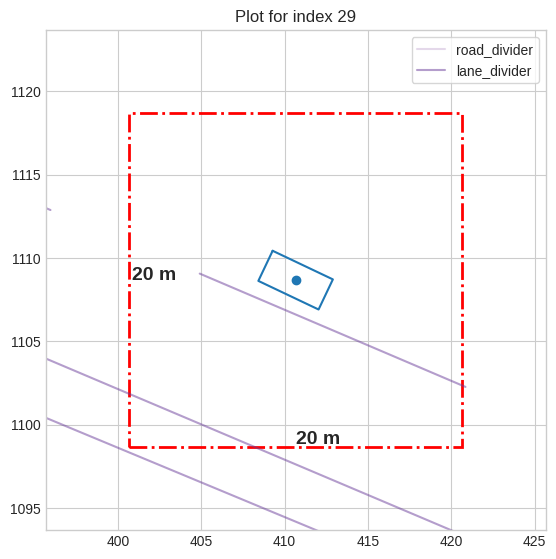

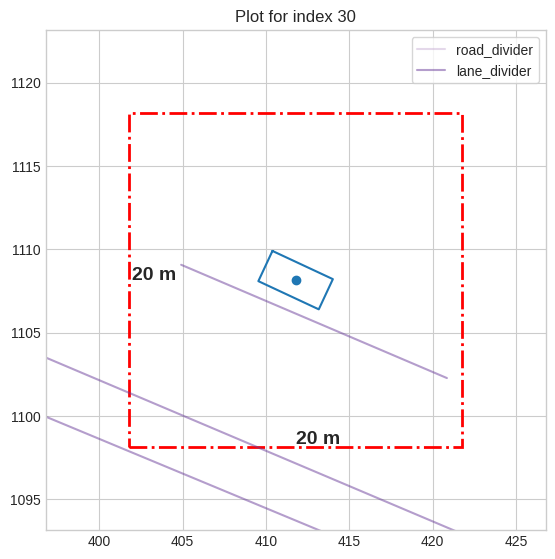

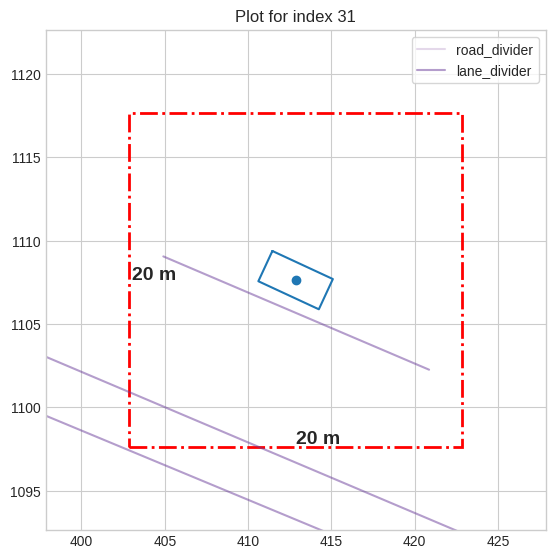

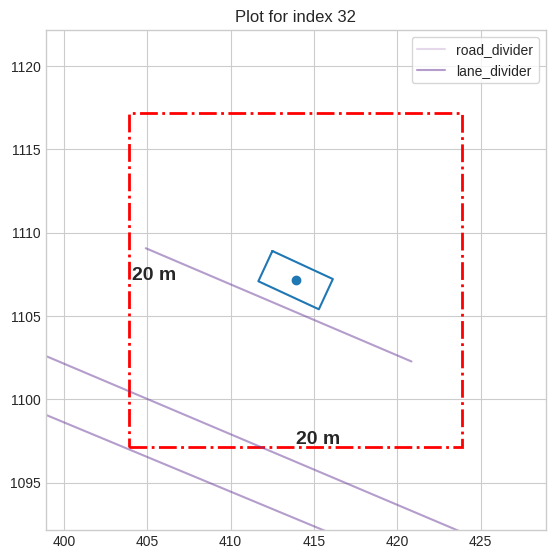

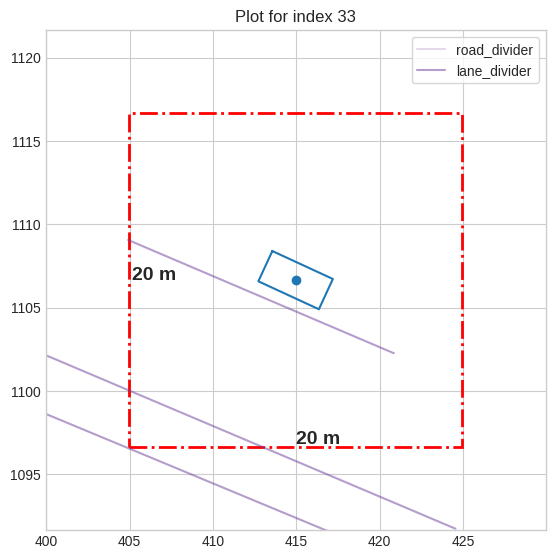

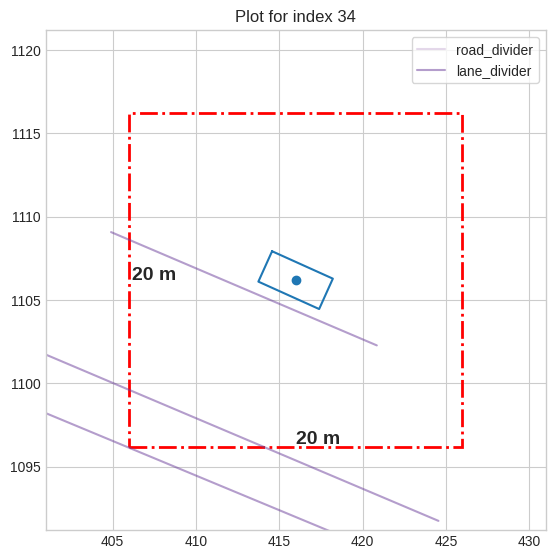

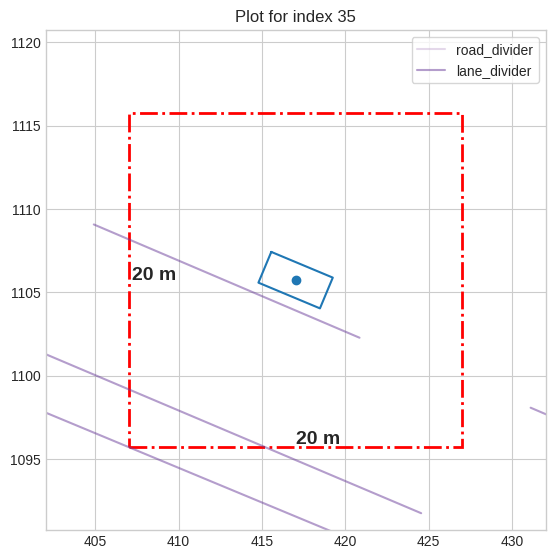

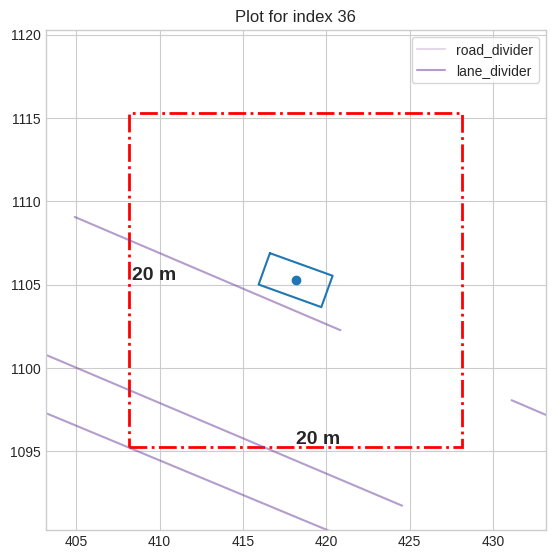

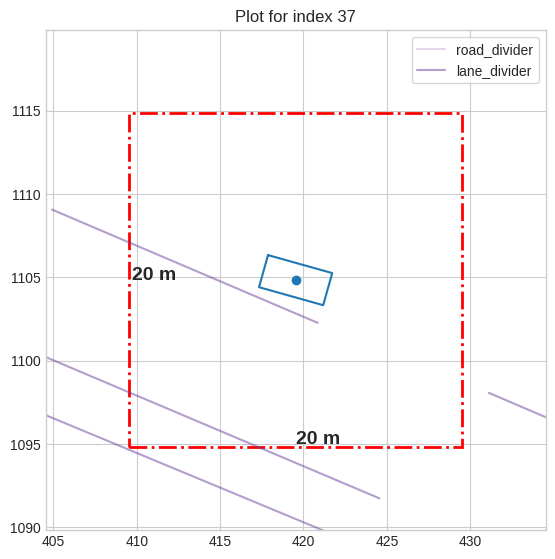

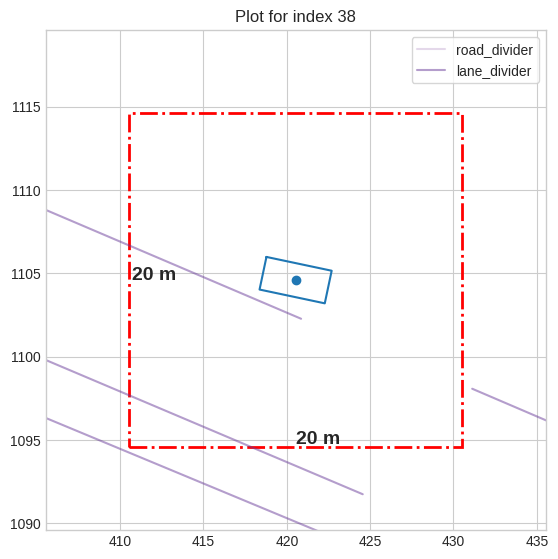

In [8]:

for i in range(example_scene_df.shape[0]):
    x,y,yaw = example_scene_df.iloc[i][['x','y', 'yaw']].tolist()
    yaw =  math.degrees(-(math.pi / 2) + yaw)
    if True:#is_on_divider(x,y,yaw, (2,4), ['road_divider', 'lane_divider']) in [True]:

         #for visual confirmation
        patch_size = 20
        patch_box = [x,y, patch_size, patch_size]
        patch = NuScenesMapExplorer.get_patch_coord(patch_box)
        minx, miny, maxx, maxy = patch.bounds

        fig, ax = nusc_map.render_map_patch( [minx, miny, maxx, maxy], ['road_divider', 'lane_divider'], figsize=(5, 5))
        
        ax.scatter(x,y)

        rotated_rectangle = create_rotated_rectangle((x,y), yaw, (2,4))
        x,y = rotated_rectangle.exterior.xy
        ax.plot(x,y)
    
        plt.title(f'Plot for index {i}')
        plt.show()
